In [1]:
import torch
import torch.autograd as autograd         # computation graph
from torch import Tensor                  # tensor node in the computation graph
import torch.nn as nn                     # neural networks
import torch.optim as optim               # optimizers e.g. gradient descent, ADAM, etc.

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from mpl_toolkits.axes_grid1 import make_axes_locatable
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.ticker
from torch.nn.parameter import Parameter

import numpy as np
import time
from pyDOE import lhs         #Latin Hypercube Sampling
import scipy.io

from smt.sampling_methods import LHS
from scipy.io import savemat

#Set default dtype to float32
torch.set_default_dtype(torch.float)

#PyTorch random number generator
torch.manual_seed(1234)

# Random number generators in other libraries
np.random.seed(1234)

device = torch.device('cpu')

print(device)

if device == 'cuda': 
    print(torch.cuda.get_device_name())

cpu


In [2]:
def true_2D_1(xt): #True function for 2D_1 Klein Gordon Equation x \in [-50,50] , t \in [0,10]
    y = xt[:,0]*np.cos(xt[:,1])
    return y.reshape(-1,1)    
    

In [3]:
x = np.linspace(-5,5,500).reshape(-1,1)
t = np.linspace(0,10,1000).reshape(-1,1)

X,T = np.meshgrid(x,t)

X = X.flatten('F').reshape(-1,1)
T = T.flatten('F').reshape(-1,1)
  
xt = np.hstack((X,T))

u_true = true_2D_1(xt)

bound_pts_idx = ((X == -5) + (X == 5) + (T == 0)).reshape(-1,)

xt_bound = xt[bound_pts_idx,:]
y_bound = u_true[bound_pts_idx,:]


xt_test_tensor = torch.from_numpy(xt).float().to(device)


lb_xt = xt[0]
ub_xt = xt[-1]

In [4]:
prob_name = "KG_"

In [5]:
data_stan = scipy.io.loadmat('./stan/'+prob_name+'stan.mat')
data_tanh = scipy.io.loadmat('./tanh/'+prob_name+'tanh.mat')
data_atanh = scipy.io.loadmat('./atanh/'+prob_name+'atanh.mat')
data_swish = scipy.io.loadmat('./swish/'+prob_name+'swish.mat')
data_rowdy = scipy.io.loadmat('./rowdy/'+prob_name+'rowdy.mat')

num_steps = 200

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


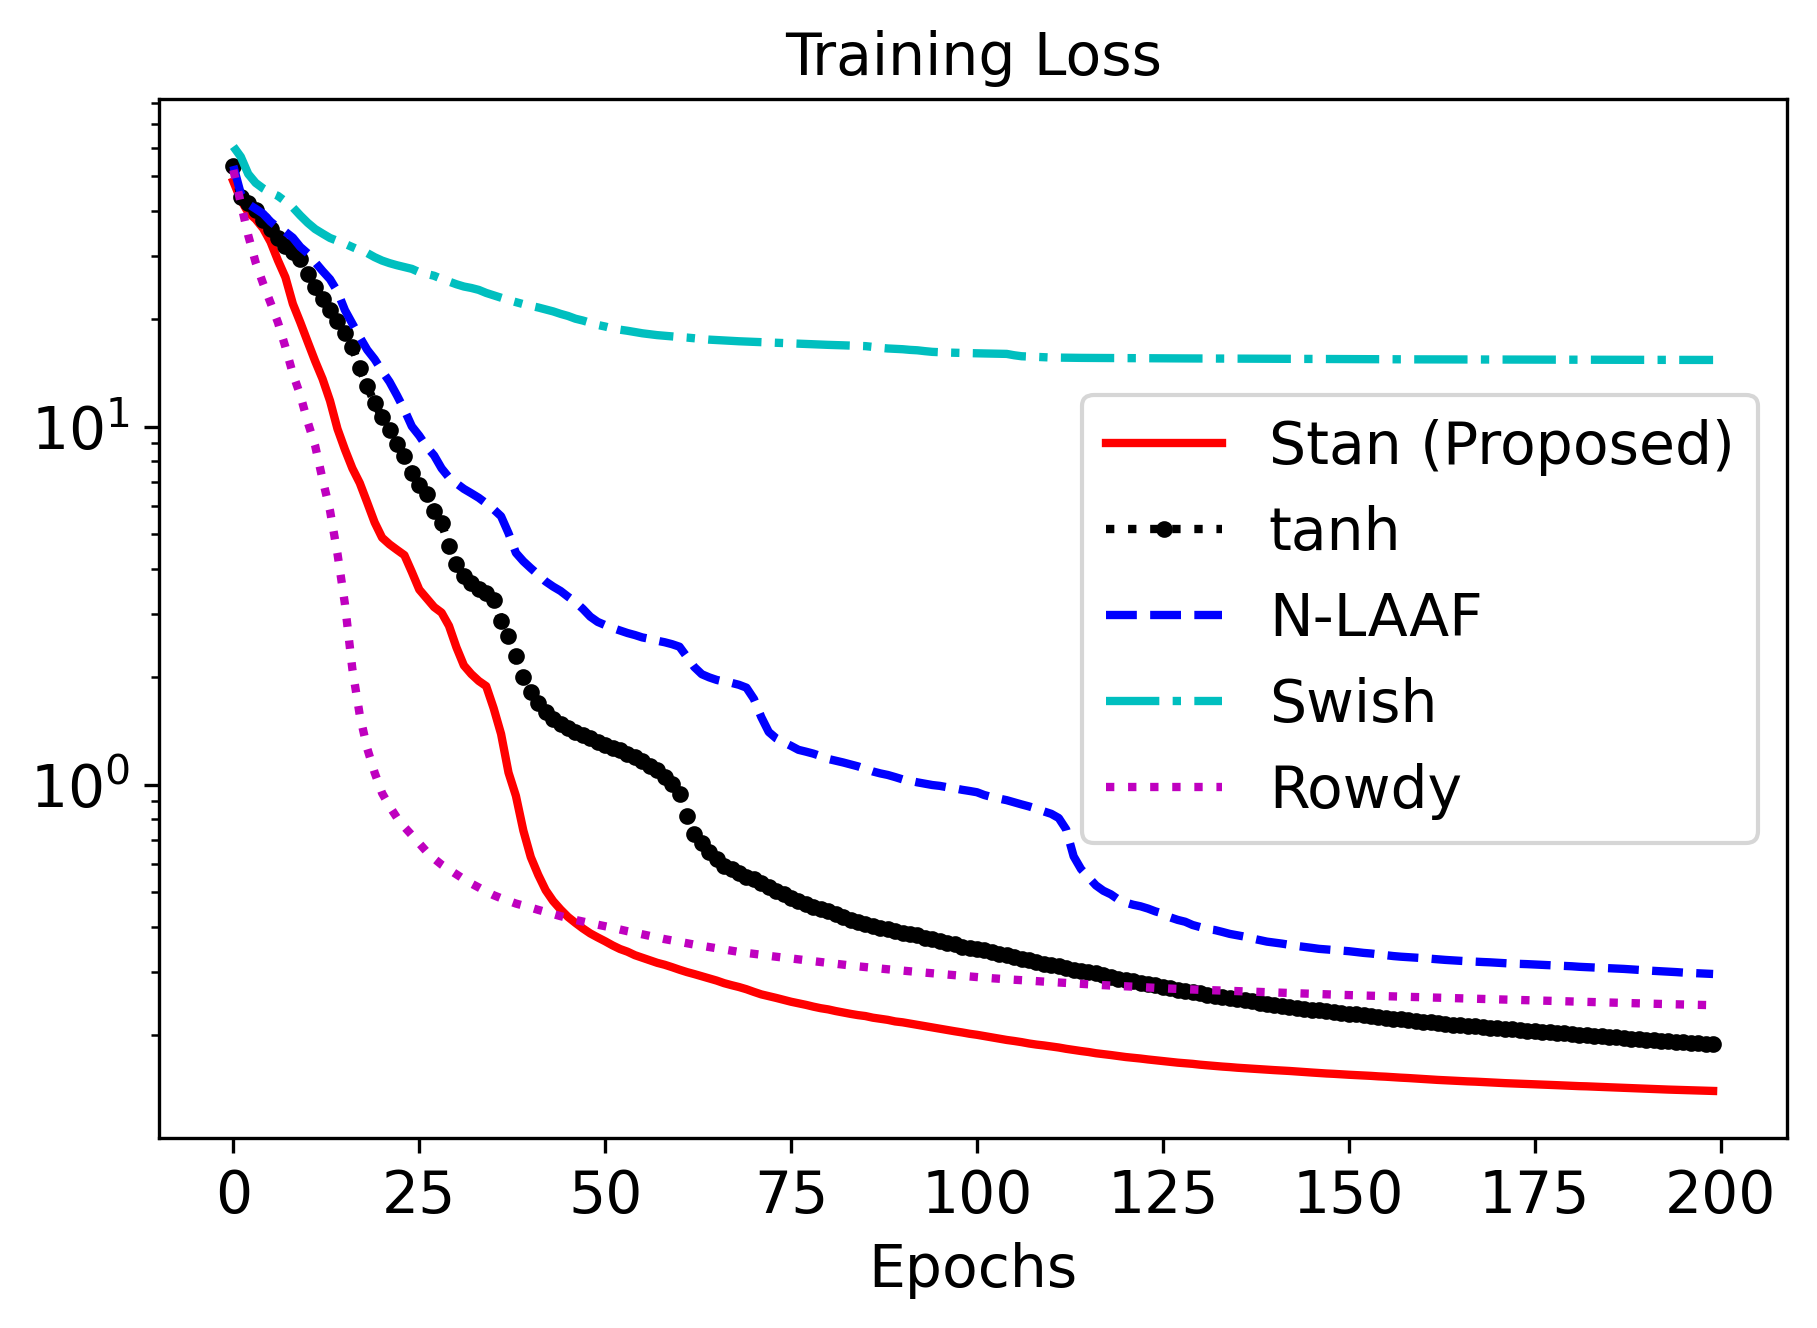

In [6]:
train_loss_stan =  data_stan['train_loss']
train_loss_tanh =  data_tanh['train_loss']
train_loss_atanh =  data_atanh['train_loss']
train_loss_swish =  data_swish['train_loss']
train_loss_rowdy =  data_rowdy['train_loss']


mean_train_loss_stan = np.zeros((num_steps,1))
mean_train_loss_tanh = np.zeros((num_steps,1))
mean_train_loss_atanh = np.zeros((num_steps,1))
mean_train_loss_swish = np.zeros((num_steps,1))
mean_train_loss_rowdy = np.zeros((num_steps,1))


for i in range(10):
    mean_train_loss_stan = mean_train_loss_stan + train_loss_stan[i,:num_steps].reshape(-1,1)
    mean_train_loss_tanh = mean_train_loss_tanh + train_loss_tanh[i,:num_steps].reshape(-1,1)
    mean_train_loss_atanh = mean_train_loss_atanh + train_loss_atanh[i,:num_steps].reshape(-1,1)
    mean_train_loss_swish = mean_train_loss_swish + train_loss_swish[i,:num_steps].reshape(-1,1)
    mean_train_loss_rowdy = mean_train_loss_rowdy + train_loss_rowdy[i,:num_steps].reshape(-1,1)
    
        
mean_train_loss_stan = mean_train_loss_stan/10
mean_train_loss_tanh = mean_train_loss_tanh/10
mean_train_loss_atanh = mean_train_loss_atanh/10
mean_train_loss_swish = mean_train_loss_swish/10
mean_train_loss_rowdy = mean_train_loss_rowdy/10


fig, ax = plt.subplots()
ax.plot(mean_train_loss_stan,'r',linewidth = 2,label = 'Stan (Proposed)')
ax.plot(mean_train_loss_tanh,'k:.', linewidth = 2,label = 'tanh')
ax.plot(mean_train_loss_atanh,'b--',linewidth = 2, label = 'N-LAAF')
ax.plot(mean_train_loss_swish,'c-.',linewidth = 2,label = 'Swish')
ax.plot(mean_train_loss_rowdy,'m:',linewidth = 2, label = 'Rowdy')

#ax.set_fontvariant('normal')

fig.dpi=300
fig.tight_layout()

ax.set_yscale('log')
ax.legend(prop={'size':14})
#ax.set_ylim([0,5])
ax.set_title('Training Loss', fontsize=14)
ax.set_xlabel('Epochs',fontsize=14,alpha = 1)
ax.tick_params(axis='x', labelsize=14)
ax.tick_params(axis='y', labelsize=14)
 
fig.savefig(prob_name+'train_loss.eps', format='eps',pad_inches=0, bbox_inches='tight')

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


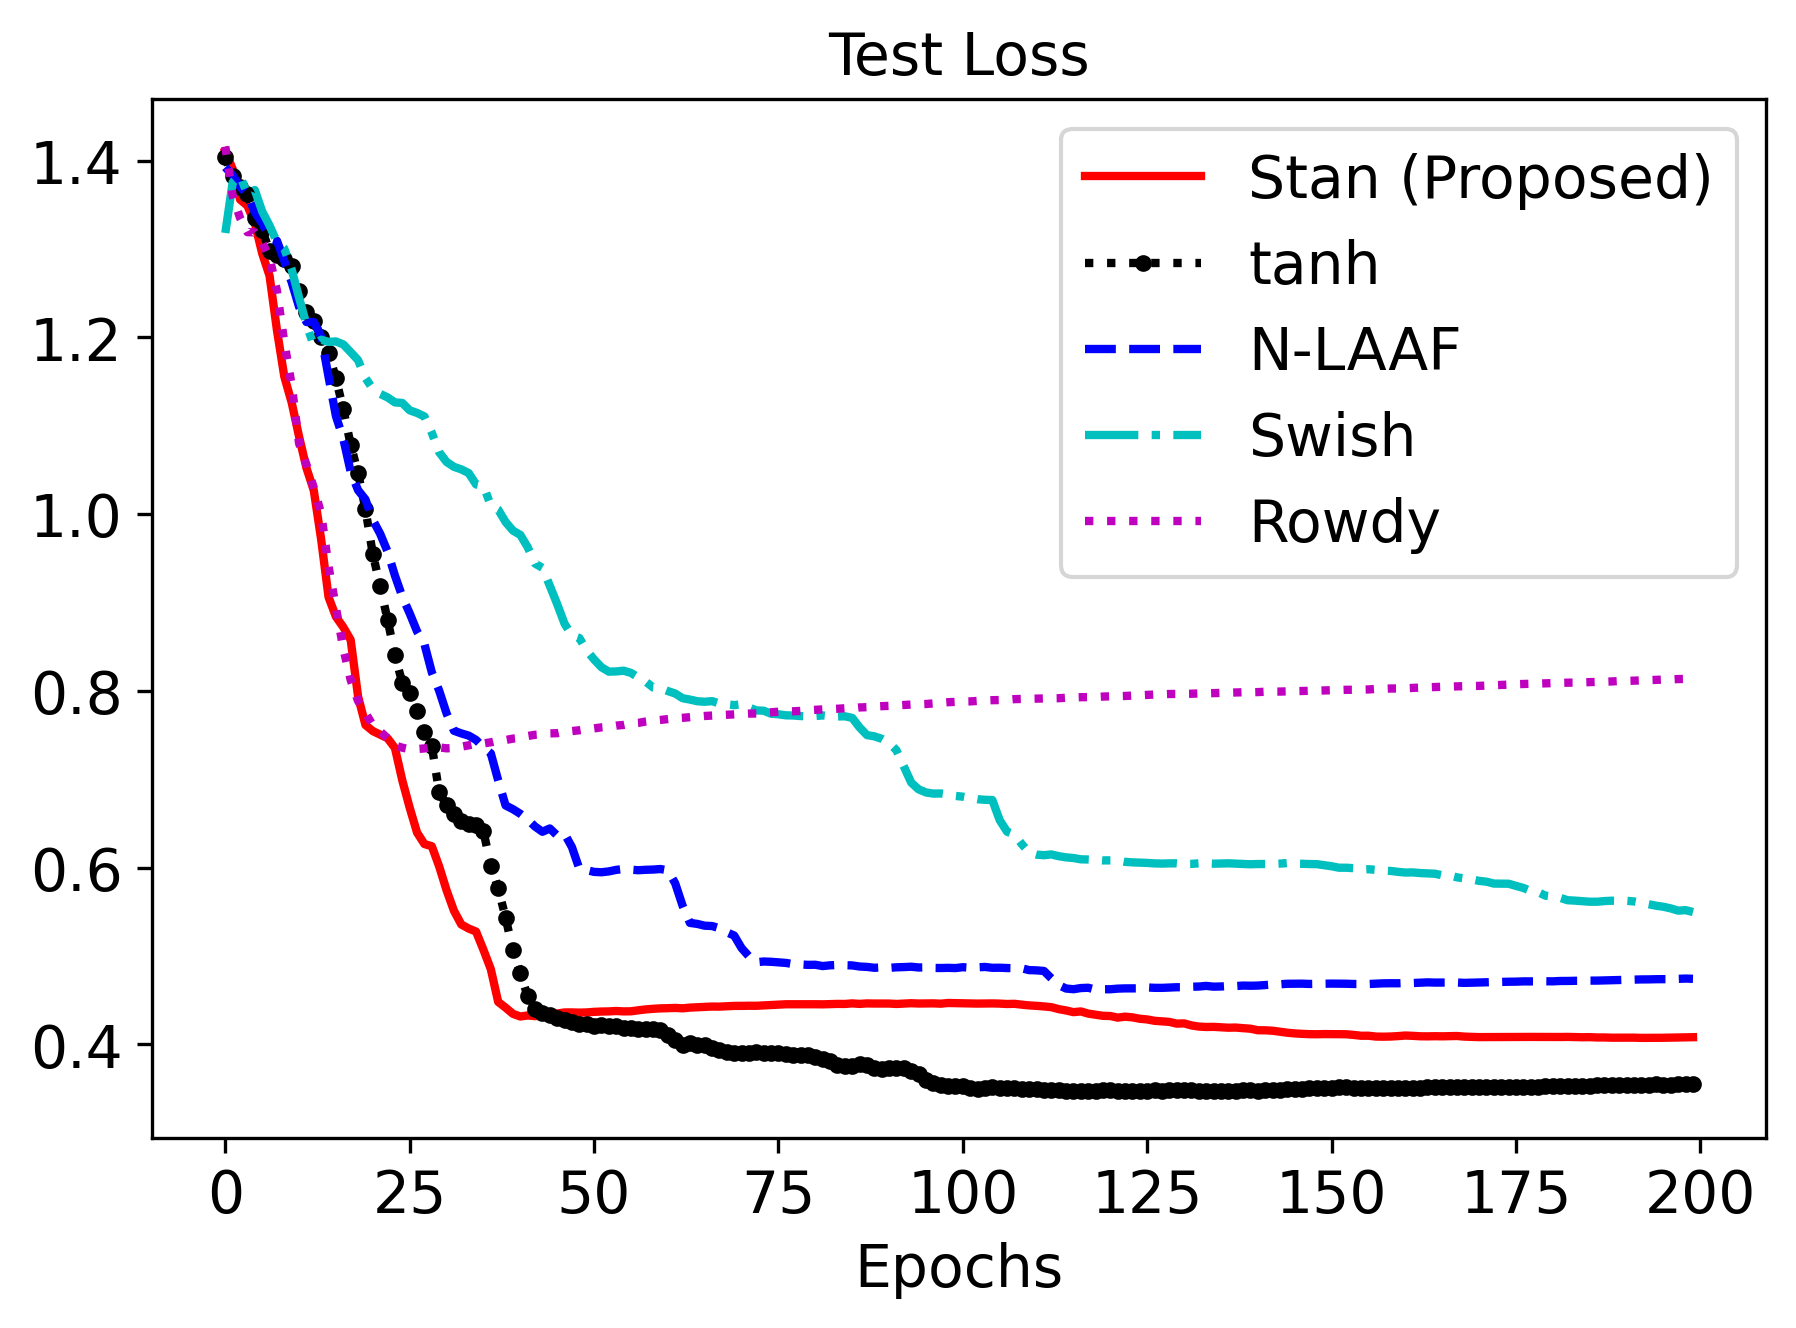

In [7]:
test_loss_stan =  data_stan['test_re_loss']
test_loss_tanh =  data_tanh['test_re_loss']
test_loss_atanh =  data_atanh['test_re_loss']
test_loss_swish =  data_swish['test_re_loss']
test_loss_rowdy =  data_rowdy['test_re_loss']


mean_test_loss_stan = np.zeros((num_steps,1))
mean_test_loss_tanh = np.zeros((num_steps,1))
mean_test_loss_atanh = np.zeros((num_steps,1))
mean_test_loss_swish = np.zeros((num_steps,1))
mean_test_loss_rowdy = np.zeros((num_steps,1))


for i in range(10):
    mean_test_loss_stan = mean_test_loss_stan + test_loss_stan[i,:num_steps].reshape(-1,1)
    mean_test_loss_tanh = mean_test_loss_tanh + test_loss_tanh[i,:num_steps].reshape(-1,1)
    mean_test_loss_atanh = mean_test_loss_atanh + test_loss_atanh[i,:num_steps].reshape(-1,1)
    mean_test_loss_swish = mean_test_loss_swish + test_loss_swish[i,:num_steps].reshape(-1,1)
    mean_test_loss_rowdy = mean_test_loss_rowdy + test_loss_rowdy[i,:num_steps].reshape(-1,1)
    
        
mean_test_loss_stan = mean_test_loss_stan/10
mean_test_loss_tanh = mean_test_loss_tanh/10
mean_test_loss_atanh = mean_test_loss_atanh/10
mean_test_loss_swish = mean_test_loss_swish/10
mean_test_loss_rowdy = mean_test_loss_rowdy/10


fig, ax = plt.subplots()
ax.plot(mean_test_loss_stan,'r',linewidth = 2,label = 'Stan (Proposed)')
ax.plot(mean_test_loss_tanh,'k:.',linewidth = 2, label = 'tanh')
ax.plot(mean_test_loss_atanh,'b--',linewidth = 2, label = 'N-LAAF')
ax.plot(mean_test_loss_swish,'c-.',linewidth = 2,label = 'Swish')
ax.plot(mean_test_loss_rowdy,'m:',linewidth = 2, label = 'Rowdy')

#ax.set_fontvariant('normal')

fig.dpi=300
fig.tight_layout()

#ax.set_yscale('log')
ax.legend(prop={'size':14})
#ax.set_ylim([0,6])
ax.set_title('Test Loss', fontsize=14)
ax.set_xlabel('Epochs',fontsize=14,alpha = 1)
ax.tick_params(axis='x', labelsize=14)
ax.tick_params(axis='y', labelsize=14)
 
fig.savefig(prob_name + 're.eps', format='eps',pad_inches=0, bbox_inches='tight')

In [8]:
print(mean_test_loss_stan[-1])
print(mean_test_loss_tanh[-1])
print(mean_test_loss_atanh[-1])
print(mean_test_loss_swish[-1])
print(mean_test_loss_rowdy[-1])

[0.40823949]
[0.35509675]
[0.47432448]
[0.54988433]
[0.81369107]


In [9]:
test_loss_stan[:,-1]

array([0.90820581, 0.87393809, 0.00240958, 1.32124775, 0.00171885,
       0.00136244, 0.88790567, 0.00208312, 0.07931527, 0.00420831])

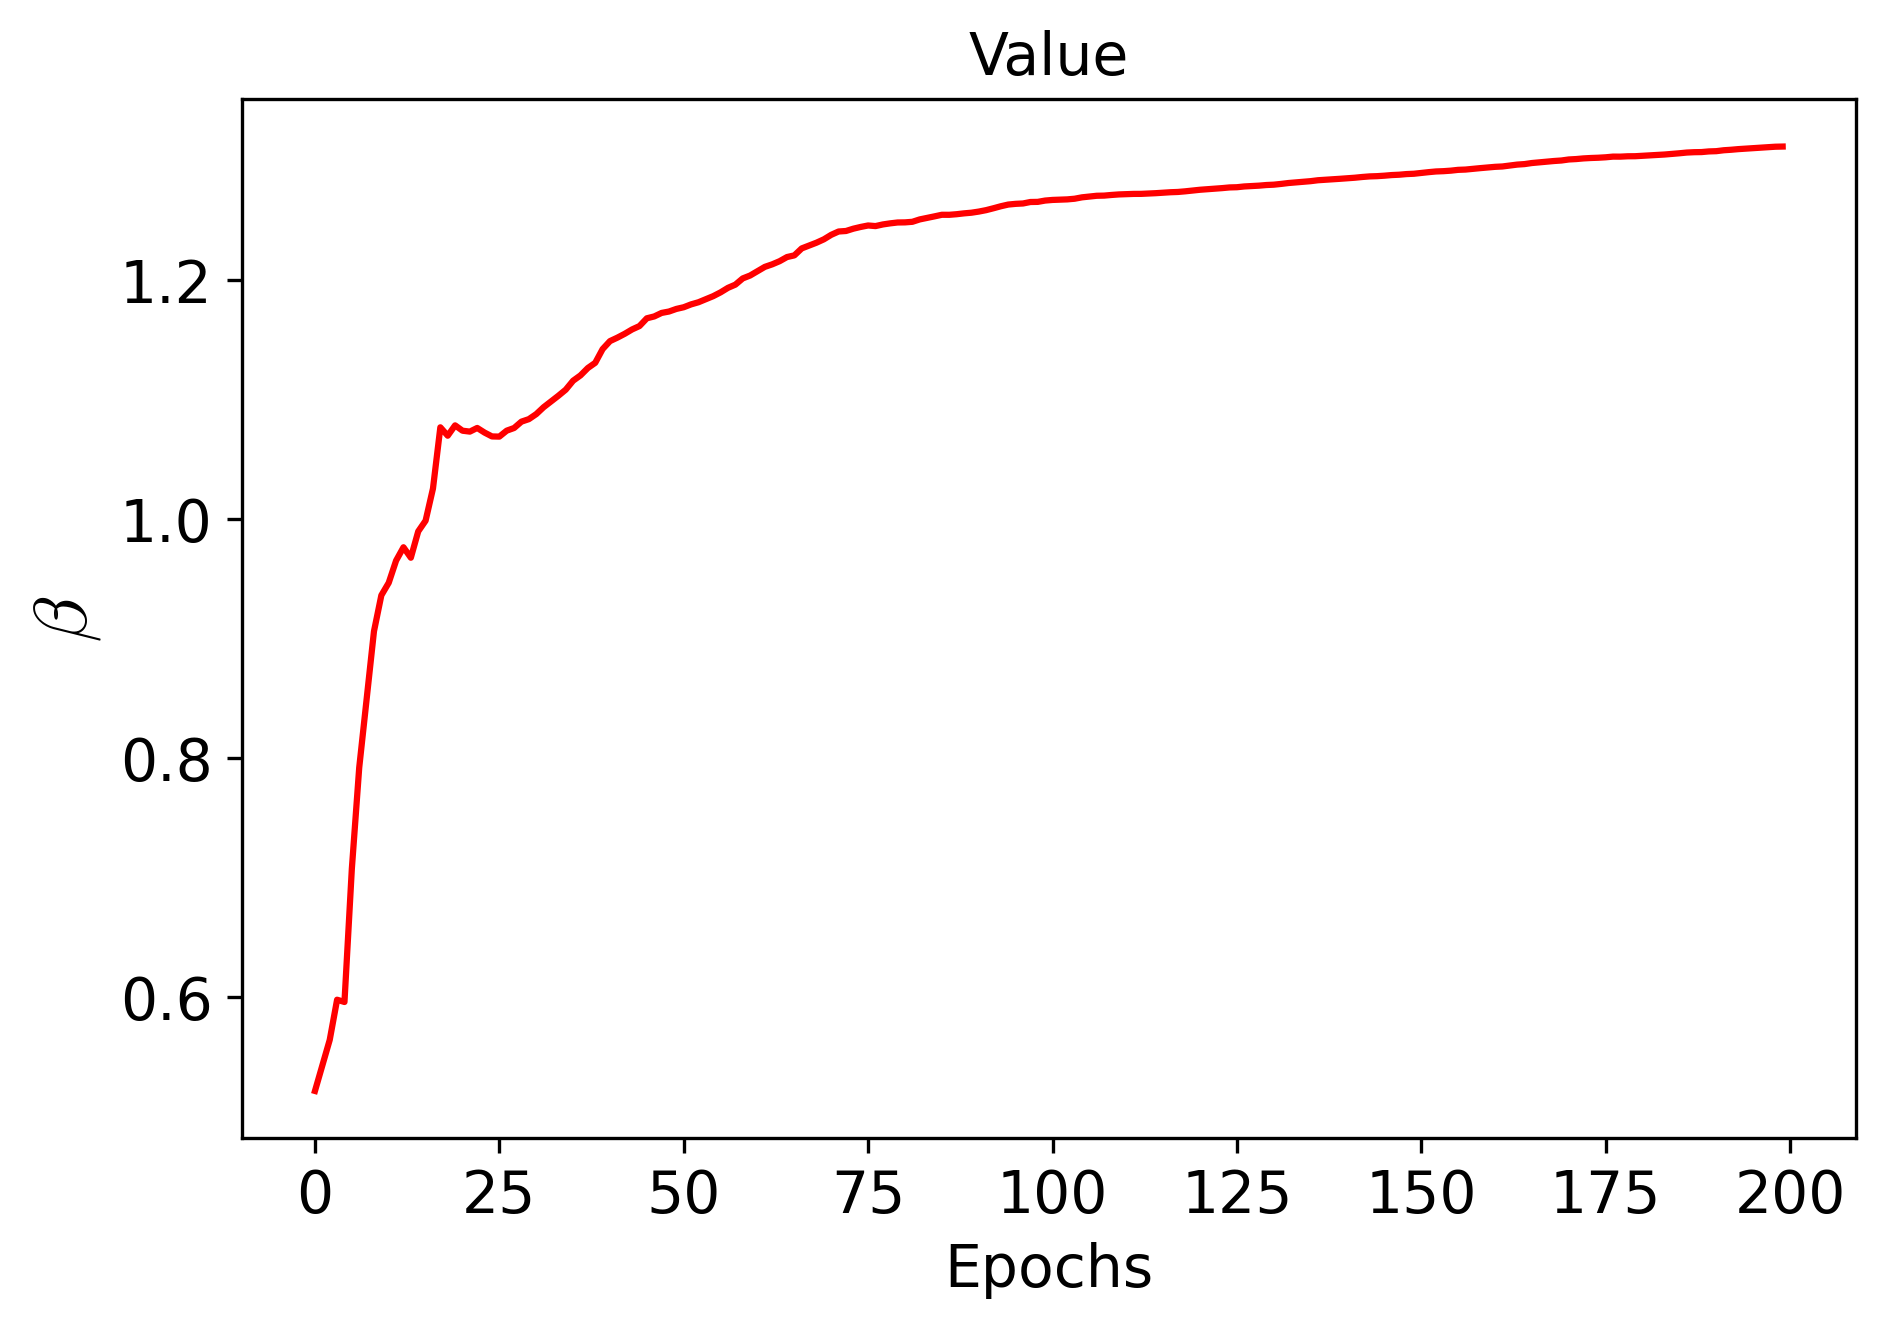

In [10]:
beta_tanhxtanh =  data_stan['beta']

beta_history = beta_tanhxtanh[0,:num_steps,20,7] #For the first repetition

fig, ax = plt.subplots()
ax.plot(beta_history,'r')

fig.dpi=300
fig.tight_layout()

ax.set_title('Value', fontsize=14, math_fontfamily='cm')
ax.set_xlabel('Epochs', fontsize=14, math_fontfamily='cm')
ax.set_ylabel('$\\beta $',fontsize=18, math_fontfamily='cm')
ax.tick_params(axis='x', labelsize=14)
ax.tick_params(axis='y', labelsize=14)
plt.savefig(prob_name + 'beta_history.eps', format='eps',pad_inches=0, bbox_inches='tight')

In [11]:
# for i in range(10):
#     print(i)
#     print(test_loss_tanhxtanh[0][i][0,-1])
#     print(train_loss_atanh[0][i][0,-1])
#     print(train_loss_tanh[0][i][0,-1])

In [12]:
class Sequentialmodel_stan(nn.Module):
    
    def __init__(self,layers,beta_init):
        super().__init__() #call __init__ from parent class 
              
        'activation function'
        self.activation = nn.Tanh()

        'loss function'
        self.loss_function = nn.MSELoss(reduction ='mean')
        
        'Initialise neural network as a list using nn.Modulelist'  
        self.linears = nn.ModuleList([nn.Linear(layers[i], layers[i+1]) for i in range(len(layers)-1)])
        
        # std = gain * sqrt(2/(input_dim+output_dim))
        for i in range(len(layers)-1):
            nn.init.xavier_normal_(self.linears[i].weight.data, gain=1.0)
            # set biases to zero
            nn.init.zeros_(self.linears[i].bias.data)
            
        
        self.beta = Parameter(beta_init*torch.ones((50,len(layers)-2)))
        self.beta.requiresGrad = True

            
    'foward pass'
    def forward(self,xt):
        if torch.is_tensor(xt) != True:         
            xt = torch.from_numpy(xt)                
        
        ubxt = torch.from_numpy(ub_xt).float().to(device)
        lbxt = torch.from_numpy(lb_xt).float().to(device)
    
                      
        #preprocessing input 
        xt = (xt - lbxt)/(ubxt - lbxt)
        
        #convert to float
        a = xt.float()
        
        for i in range(len(layers)-2):
            z = self.linears[i](a)
            a = self.activation(z) + self.beta[:,i]*z*self.activation(z)
            
        a = self.linears[-1](a) 
         
        return a
                        
    def loss_BC(self,xt,y):
                
        loss_bc = self.loss_function(self.forward(xt), y)
                
        return loss_bc
    
    def loss_PDE(self, xt_coll, f_hat):
        
        g = xt_coll.clone()             
        g.requires_grad = True
        y = self.forward(g) 
        
        
        y_x_t = autograd.grad(y,g,torch.ones([xt_coll.shape[0], 1]).to(device), retain_graph=True, create_graph=True,allow_unused = True)[0]
        
        y_xx_tt = autograd.grad(y_x_t,g,torch.ones(xt_coll.shape).to(device), create_graph=True,allow_unused = True)[0]

        #du_dx = u_x_t[:,[0]]
        
        d2y_dx2 = y_xx_tt[:,[0]]
        d2y_dt2 = y_xx_tt[:,[1]]    
        

        f = d2y_dt2 - d2y_dx2 + torch.pow(y,2) + (g[:,0]*torch.cos(g[:,1])).reshape(-1,1) - (torch.pow(g[:,0],2)*torch.pow(torch.cos(g[:,1]),2)).reshape(-1,1)
        
        loss_f = self.loss_function(f,f_hat)
                
        return loss_f
    
    def loss(self,xt_BC,y_BC,xt_coll,f_hat):

        loss_BC = self.loss_BC(xt_BC,y_BC)
        loss_f = self.loss_PDE(xt_coll,f_hat)
        
        loss_val = loss_BC + loss_f
        
        return loss_val
         
    'test neural network'
    def test(self):
        y_pred = self.forward(xt_test_tensor)
        y_pred = y_pred.cpu().detach().numpy()
   
        return y_pred
    
    def test_loss(self):
        y_pred = self.test()
        
        test_mse = np.mean(np.square(y_pred.reshape(-1,1) - y_true.reshape(-1,1)))
        test_re = np.linalg.norm(y_pred.reshape(-1,1) - y_true.reshape(-1,1),2)/y_true_norm
        
        return test_mse, test_re

#--------------------------------------------------------------------------------------------------------------
class Sequentialmodel_tanh(nn.Module):
    
    def __init__(self,layers):
        super().__init__() #call __init__ from parent class 
              
        'activation function'
        self.activation = nn.Tanh()

        'loss function'
        self.loss_function = nn.MSELoss(reduction ='mean')
        
        'Initialise neural network as a list using nn.Modulelist'  
        self.linears = nn.ModuleList([nn.Linear(layers[i], layers[i+1]) for i in range(len(layers)-1)])
        
        # std = gain * sqrt(2/(input_dim+output_dim))
        for i in range(len(layers)-1):
            nn.init.xavier_normal_(self.linears[i].weight.data, gain=1.0)
            # set biases to zero
            nn.init.zeros_(self.linears[i].bias.data)
            
        

            
    'foward pass'
    def forward(self,xt):
        if torch.is_tensor(xt) != True:         
            xt = torch.from_numpy(xt)                
        
        ubxt = torch.from_numpy(ub_xt).float().to(device)
        lbxt = torch.from_numpy(lb_xt).float().to(device)
    
                      
        #preprocessing input 
        xt = (xt - lbxt)/(ubxt - lbxt)
        
        #convert to float
        a = xt.float()
        
        for i in range(len(layers)-2):
            z = self.linears[i](a)
            a = self.activation(z)
            
        a = self.linears[-1](a) 
         
        return a
                        
    def loss_BC(self,xt,y):
                
        loss_bc = self.loss_function(self.forward(xt), y)
                
        return loss_bc
    
    def loss_PDE(self, xt_coll, f_hat):
        
        g = xt_coll.clone()             
        g.requires_grad = True
        y = self.forward(g) 
        
        
        y_x_t = autograd.grad(y,g,torch.ones([xt_coll.shape[0], 1]).to(device), retain_graph=True, create_graph=True,allow_unused = True)[0]
        
        y_xx_tt = autograd.grad(y_x_t,g,torch.ones(xt_coll.shape).to(device), create_graph=True,allow_unused = True)[0]

        #du_dx = u_x_t[:,[0]]
        
        d2y_dx2 = y_xx_tt[:,[0]]
        d2y_dt2 = y_xx_tt[:,[1]]    
        

        f = d2y_dt2 - d2y_dx2 + torch.pow(y,2) + (g[:,0]*torch.cos(g[:,1])).reshape(-1,1) - (torch.pow(g[:,0],2)*torch.pow(torch.cos(g[:,1]),2)).reshape(-1,1)
        
        loss_f = self.loss_function(f,f_hat)
                
        return loss_f
    
    def loss(self,xt_BC,y_BC,xt_coll,f_hat):

        loss_BC = self.loss_BC(xt_BC,y_BC)
        loss_f = self.loss_PDE(xt_coll,f_hat)
        
        loss_val = loss_BC + loss_f
        
        return loss_val
         
    'test neural network'
    def test(self):
        y_pred = self.forward(xt_test_tensor)
        y_pred = y_pred.cpu().detach().numpy()
   
        return y_pred
    
    def test_loss(self):
        y_pred = self.test()
        
        test_mse = np.mean(np.square(y_pred.reshape(-1,1) - y_true.reshape(-1,1)))
        test_re = np.linalg.norm(y_pred.reshape(-1,1) - y_true.reshape(-1,1),2)/y_true_norm
        
        return test_mse, test_re  
    
#---------------------------------------------------------------------------------------------------------
class Sequentialmodel_atanh(nn.Module):
    
    def __init__(self,layers,n_val):
        super().__init__() #call __init__ from parent class 
              
        'activation function'
        self.activation = nn.Tanh()

        'loss function'
        self.loss_function = nn.MSELoss(reduction ='mean')
        
        'Initialise neural network as a list using nn.Modulelist'  
        self.linears = nn.ModuleList([nn.Linear(layers[i], layers[i+1]) for i in range(len(layers)-1)])
        
        # std = gain * sqrt(2/(input_dim+output_dim))
        for i in range(len(layers)-1):
            nn.init.xavier_normal_(self.linears[i].weight.data, gain=1.0)
            # set biases to zero
            nn.init.zeros_(self.linears[i].bias.data)
            
        
        self.alpha = Parameter(torch.ones((50,len(layers)-2)))
        self.alpha.requiresGrad = True
        
        self.n = torch.tensor(n_val)

            
    'foward pass'
    def forward(self,xt):
        if torch.is_tensor(xt) != True:         
            xt = torch.from_numpy(xt)                
        
        ubxt = torch.from_numpy(ub_xt).float().to(device)
        lbxt = torch.from_numpy(lb_xt).float().to(device)
    
                      
        #preprocessing input 
        xt = (xt - lbxt)/(ubxt - lbxt)
        
        #convert to float
        a = xt.float()
        
        for i in range(len(layers)-2):
            z = self.linears[i](a)
            a = self.activation(self.n*self.alpha[:,i]*z)
            
        a = self.linears[-1](a) 
         
        return a
                        
    def loss_BC(self,xt,y):
                
        loss_bc = self.loss_function(self.forward(xt), y)
                
        return loss_bc
    
    def loss_PDE(self, xt_coll, f_hat):
        
        g = xt_coll.clone()             
        g.requires_grad = True
        y = self.forward(g) 
        
        
        y_x_t = autograd.grad(y,g,torch.ones([xt_coll.shape[0], 1]).to(device), retain_graph=True, create_graph=True,allow_unused = True)[0]
        
        y_xx_tt = autograd.grad(y_x_t,g,torch.ones(xt_coll.shape).to(device), create_graph=True,allow_unused = True)[0]

        #du_dx = u_x_t[:,[0]]
        
        d2y_dx2 = y_xx_tt[:,[0]]
        d2y_dt2 = y_xx_tt[:,[1]]    
        

        f = d2y_dt2 - d2y_dx2 + torch.pow(y,2) + (g[:,0]*torch.cos(g[:,1])).reshape(-1,1) - (torch.pow(g[:,0],2)*torch.pow(torch.cos(g[:,1]),2)).reshape(-1,1)
        
        loss_f = self.loss_function(f,f_hat)
                
        return loss_f
    
    def loss(self,xt_BC,y_BC,xt_coll,f_hat):

        loss_BC = self.loss_BC(xt_BC,y_BC)
        loss_f = self.loss_PDE(xt_coll,f_hat)
        
        loss_val = loss_BC + loss_f
        
        return loss_val
         
    'test neural network'
    def test(self):
        y_pred = self.forward(xt_test_tensor)
        y_pred = y_pred.cpu().detach().numpy()
   
        return y_pred
    
    def test_loss(self):
        y_pred = self.test()
        
        test_mse = np.mean(np.square(y_pred.reshape(-1,1) - y_true.reshape(-1,1)))
        test_re = np.linalg.norm(y_pred.reshape(-1,1) - y_true.reshape(-1,1),2)/y_true_norm
        
        return test_mse, test_re  
#--------------------------------------------------------------------------------------------------------------------
class Sequentialmodel_swish(nn.Module):
    
    def __init__(self,layers):
        super().__init__() #call __init__ from parent class 
              
        'activation function'
        self.activation = nn.Sigmoid()

        'loss function'
        self.loss_function = nn.MSELoss(reduction ='mean')
        
        'Initialise neural network as a list using nn.Modulelist'  
        self.linears = nn.ModuleList([nn.Linear(layers[i], layers[i+1]) for i in range(len(layers)-1)])
        
        # std = gain * sqrt(2/(input_dim+output_dim))
        for i in range(len(layers)-1):
            nn.init.xavier_normal_(self.linears[i].weight.data, gain=1.0)
            # set biases to zero
            nn.init.zeros_(self.linears[i].bias.data)
            
        
        self.beta = Parameter(torch.ones((50,len(layers)-2)))
        self.beta.requiresGrad = True

            
    'foward pass'
    def forward(self,xt):
        if torch.is_tensor(xt) != True:         
            xt = torch.from_numpy(xt)                
        
        ubxt = torch.from_numpy(ub_xt).float().to(device)
        lbxt = torch.from_numpy(lb_xt).float().to(device)
    
                      
        #preprocessing input 
        xt = (xt - lbxt)/(ubxt - lbxt)
        
        #convert to float
        a = xt.float()
        
        for i in range(len(layers)-2):
            z = self.linears[i](a)
            a = z*self.activation(self.beta[:,i]*z)
            
        a = self.linears[-1](a) 
         
        return a
                        
    def loss_BC(self,xt,y):
                
        loss_bc = self.loss_function(self.forward(xt), y)
                
        return loss_bc
    
    def loss_PDE(self, xt_coll, f_hat):
        
        g = xt_coll.clone()             
        g.requires_grad = True
        y = self.forward(g) 
        
        
        y_x_t = autograd.grad(y,g,torch.ones([xt_coll.shape[0], 1]).to(device), retain_graph=True, create_graph=True,allow_unused = True)[0]
        
        y_xx_tt = autograd.grad(y_x_t,g,torch.ones(xt_coll.shape).to(device), create_graph=True,allow_unused = True)[0]

        #du_dx = u_x_t[:,[0]]
        
        d2y_dx2 = y_xx_tt[:,[0]]
        d2y_dt2 = y_xx_tt[:,[1]]    
        

        f = d2y_dt2 - d2y_dx2 + torch.pow(y,2) + (g[:,0]*torch.cos(g[:,1])).reshape(-1,1) - (torch.pow(g[:,0],2)*torch.pow(torch.cos(g[:,1]),2)).reshape(-1,1)
        
        loss_f = self.loss_function(f,f_hat)
                
        return loss_f
    
    def loss(self,xt_BC,y_BC,xt_coll,f_hat):

        loss_BC = self.loss_BC(xt_BC,y_BC)
        loss_f = self.loss_PDE(xt_coll,f_hat)
        
        loss_val = loss_BC + loss_f
        
        return loss_val
         
    'test neural network'
    def test(self):
        y_pred = self.forward(xt_test_tensor)
        y_pred = y_pred.cpu().detach().numpy()
   
        return y_pred
    
    def test_loss(self):
        y_pred = self.test()
        
        test_mse = np.mean(np.square(y_pred.reshape(-1,1) - y_true.reshape(-1,1)))
        test_re = np.linalg.norm(y_pred.reshape(-1,1) - y_true.reshape(-1,1),2)/y_true_norm
        
        return test_mse, test_re  
#-------------------------------------------------------------------------------------------------------------------------
class Sequentialmodel_rowdy(nn.Module):
    
    def __init__(self,layers,n_val,rowdy_terms):
        super().__init__() #call __init__ from parent class 
              
        'activation function'
        self.activation = nn.Tanh()

        'loss function'
        self.loss_function = nn.MSELoss(reduction ='mean')
        
        'Initialise neural network as a list using nn.Modulelist'  
        self.linears = nn.ModuleList([nn.Linear(layers[i], layers[i+1]) for i in range(len(layers)-1)])
        
        # std = gain * sqrt(2/(input_dim+output_dim))
        for i in range(len(layers)-1):
            nn.init.xavier_normal_(self.linears[i].weight.data, gain=1.0)
            # set biases to zero
            nn.init.zeros_(self.linears[i].bias.data)
            
        
        self.omega1 = Parameter(torch.ones((len(layers)-2,1))) 
        self.omega1.requiresGrad = True
        
        
        self.alpha = Parameter(torch.zeros(rowdy_terms,len(layers)-2))
        self.alpha.requiresGrad = True
        
        
        self.omega = Parameter((1/n_val)*torch.ones(rowdy_terms,len(layers)-2))
        self.omega.requiresGrad = True
        
        self.n = torch.tensor(n_val)

            
    'foward pass'
    def forward(self,xt):
        if torch.is_tensor(xt) != True:         
            xt = torch.from_numpy(xt)                
        
        ubxt = torch.from_numpy(ub_xt).float().to(device)
        lbxt = torch.from_numpy(lb_xt).float().to(device)
    
                      
        #preprocessing input 
        xt = (xt - lbxt)/(ubxt - lbxt)
        
        #convert to float
        a = xt.float()
        
        for i in range(len(layers)-2):
            z = self.linears[i](a)
            a = self.activation(self.omega1[i,0]*z)
            for j in range(rowdy_terms):
                a = a + self.alpha[j,i]*self.n*torch.sin((j+1)*self.n*self.omega[j,i]*z)
            
        a = self.linears[-1](a) 
         
        return a
                        
    def loss_BC(self,xt,y):
                
        loss_bc = self.loss_function(self.forward(xt), y)
                
        return loss_bc
    
    def loss_PDE(self, xt_coll, f_hat):
        
        g = xt_coll.clone()             
        g.requires_grad = True
        y = self.forward(g) 
        
        
        y_x_t = autograd.grad(y,g,torch.ones([xt_coll.shape[0], 1]).to(device), retain_graph=True, create_graph=True,allow_unused = True)[0]
        
        y_xx_tt = autograd.grad(y_x_t,g,torch.ones(xt_coll.shape).to(device), create_graph=True,allow_unused = True)[0]

        #du_dx = u_x_t[:,[0]]
        
        d2y_dx2 = y_xx_tt[:,[0]]
        d2y_dt2 = y_xx_tt[:,[1]]    
        

        f = d2y_dt2 - d2y_dx2 + torch.pow(y,2) + (g[:,0]*torch.cos(g[:,1])).reshape(-1,1) - (torch.pow(g[:,0],2)*torch.pow(torch.cos(g[:,1]),2)).reshape(-1,1)
        
        loss_f = self.loss_function(f,f_hat)
                
        return loss_f
    
    def loss(self,xt_BC,y_BC,xt_coll,f_hat):

        loss_BC = self.loss_BC(xt_BC,y_BC)
        loss_f = self.loss_PDE(xt_coll,f_hat)
        
        loss_val = loss_BC + loss_f
        
        return loss_val
         
    'test neural network'
    def test(self):
        y_pred1 = self.forward(xt_test_tensor[:250000])
        y_pred1 = y_pred1.cpu().detach().numpy()
        
        y_pred2 = self.forward(xt_test_tensor[250000:])
          
        y_pred2 = y_pred2.cpu().detach().numpy()
        
        y_pred = np.vstack((y_pred1.reshape(-1,1),y_pred2.reshape(-1,1)))
   
        return y_pred
    
    def test_loss(self):
        y_pred = self.test()
        
        test_mse = np.mean(np.square(y_pred.reshape(-1,1) - y_true.reshape(-1,1)))
        test_re = np.linalg.norm(y_pred.reshape(-1,1) - y_true.reshape(-1,1),2)/y_true_norm
        
        return test_mse, test_re  

In [13]:
layers = np.array([2,50,50,50,50,50,50,50,50,50,1]) #9 hidden layers

beta_init = 0.5

n_val_atanh = 1.0

n_val_rowdy = 3.0
rowdy_terms = 2


model_stan = Sequentialmodel_stan(layers,beta_init)
model_tanh = Sequentialmodel_tanh(layers)
model_atanh = Sequentialmodel_atanh(layers,n_val_atanh)
model_swish = Sequentialmodel_swish(layers)
model_rowdy = Sequentialmodel_rowdy(layers,n_val_rowdy,rowdy_terms)

u_pred_stan = np.zeros((xt.shape[0],1))
u_pred_tanh = np.zeros((xt.shape[0],1))
u_pred_atanh = np.zeros((xt.shape[0],1))
u_pred_swish = np.zeros((xt.shape[0],1))
u_pred_rowdy = np.zeros((xt.shape[0],1))

models_n = 1

for i in range(5,6):
    model_stan.load_state_dict(torch.load('./stan/' + prob_name + 'stan_' +str(i)+'.pt'))
    u_pred_stan = u_pred_stan + model_stan.test()
    
    model_tanh.load_state_dict(torch.load('./tanh/' + prob_name + 'tanh_' +str(i)+'.pt'))
    u_pred_tanh = u_pred_tanh + model_tanh.test()
    
    model_atanh.load_state_dict(torch.load('./atanh/' + prob_name + 'atanh_' +str(i)+'.pt'))
    u_pred_atanh = u_pred_atanh + model_atanh.test()
    
    model_swish.load_state_dict(torch.load('./swish/' + prob_name + 'swish_'+str(i)+'.pt'))
    u_pred_swish = u_pred_swish + model_swish.test()
    
    model_rowdy.load_state_dict(torch.load('./rowdy/' + prob_name + 'rowdy_'+str(i)+'.pt'))
    u_pred_rowdy = u_pred_rowdy + model_rowdy.test()

u_pred_stan = u_pred_stan/models_n
u_pred_tanh = u_pred_tanh/models_n
u_pred_atanh = u_pred_atanh/models_n
u_pred_swish = u_pred_swish/models_n
u_pred_rowdy = u_pred_rowdy/models_n

u_pred = np.hstack((u_pred_stan,u_pred_tanh,u_pred_atanh,u_pred_swish,u_pred_rowdy))

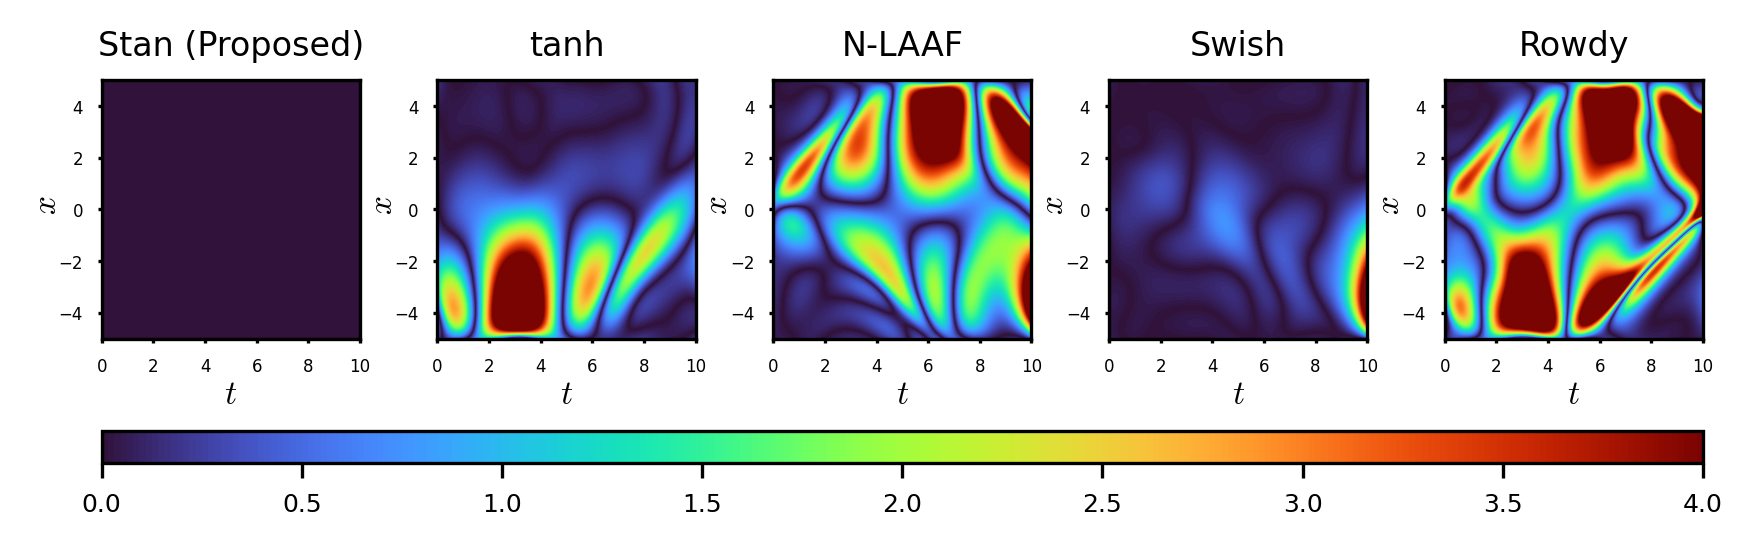

In [14]:
fig, ax = plt.subplots(1,5)

fig.dpi=300
fig.tight_layout()
cmap = plt.cm.turbo

for i in range(5):
    img = ax[i].imshow(np.abs(u_pred[:,i].reshape(-1,1) - u_true).reshape(500,1000),vmin =0,vmax =4,cmap = cmap,extent=[0,10,-5,5],aspect = 1)

    ax[i].set_xlabel('$t$', fontsize=8, math_fontfamily='cm', labelpad=0.5)
    ax[i].set_ylabel(' $x$',fontsize=8, math_fontfamily='cm', labelpad=0.5)
    
    
    ax[i].tick_params(axis='x', labelsize=4,length = 1)
    ax[i].tick_params(axis='y', labelsize=4,length = 1)
    
    ax[i].yaxis.set_label_coords(-0.15,0.5)

cbar = fig.colorbar(img, ax=ax,location = 'top',orientation = 'horizontal', aspect = 50, panchor = (0,1.3),pad = 0.15)
cbar.ax.tick_params(labelsize=6,labelbottom = True,labeltop = False, bottom =True, top = False) 

#ax.set_xticks([0,10]) 
ax[0].set_title('Stan (Proposed)',fontsize=8, math_fontfamily='cm')
ax[1].set_title('tanh',fontsize=8, math_fontfamily='cm')
ax[2].set_title('N-LAAF',fontsize=8, math_fontfamily='cm')
ax[3].set_title('Swish',fontsize=8, math_fontfamily='cm')
ax[4].set_title('Rowdy',fontsize=8, math_fontfamily='cm')


fig.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.3, hspace=None)


plt.savefig(prob_name + 'error_comparison.eps', format='eps',pad_inches=0, bbox_inches='tight')

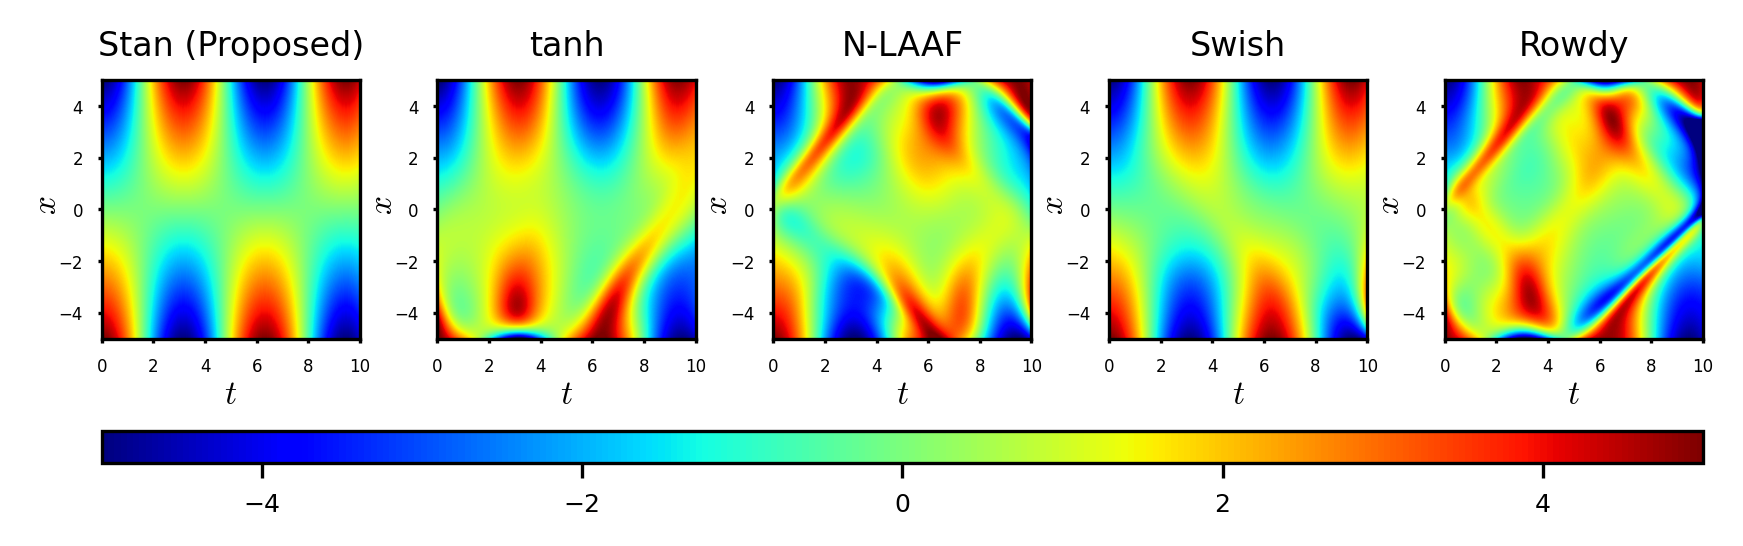

In [15]:
fig, ax = plt.subplots(1,5)

fig.dpi=300
fig.tight_layout()
cmap = plt.cm.jet

for i in range(5):
    img = ax[i].imshow(u_pred[:,i].reshape(500,1000),vmin = -5,vmax = 5,cmap = cmap,extent=[0,10,-5,5],aspect = 1)
    
    ax[i].set_xlabel('$t$', fontsize=8, math_fontfamily='cm', labelpad=0.5)
    ax[i].set_ylabel(' $x$',fontsize=8, math_fontfamily='cm', labelpad=0.5)
    
    ax[i].tick_params(axis='x', labelsize=4,length = 1)
    ax[i].tick_params(axis='y', labelsize=4,length = 1)
    
    ax[i].yaxis.set_label_coords(-0.15,0.5)
    

cbar = fig.colorbar(img, ax=ax,location = 'top',orientation = 'horizontal', aspect = 50, panchor = (0,1.3),pad = 0.15)
cbar.ax.tick_params(labelsize=6,labelbottom = True,labeltop = False, bottom =True, top = False) 


ax[0].set_title('Stan (Proposed)',fontsize=8, math_fontfamily='cm')
ax[1].set_title('tanh',fontsize=8, math_fontfamily='cm')
ax[2].set_title('N-LAAF',fontsize=8, math_fontfamily='cm')
ax[3].set_title('Swish',fontsize=8, math_fontfamily='cm')
ax[4].set_title('Rowdy',fontsize=8, math_fontfamily='cm')

fig.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.3, hspace=None)


plt.savefig(prob_name+'prediction_comparison.eps', format='eps',pad_inches=0, bbox_inches='tight')

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


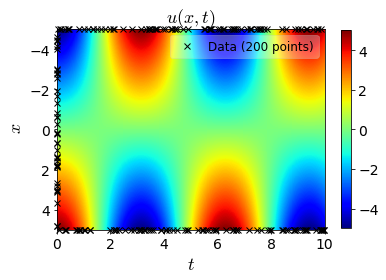

In [17]:
fig, ax = plt.subplots()

cmap = plt.cm.jet

img = ax.imshow(u_true.reshape(500,1000),vmin = -5,vmax = 5,cmap = cmap,extent=[0,10,5,-5],aspect = 0.75)

cbar = fig.colorbar(img, ax=ax,location = 'right',orientation = 'vertical', aspect = 20,pad = 0.05, extend = 'neither',shrink = 0.91)
cbar.ax.tick_params(labelsize=14,labelright = True, right = True) 

#ax.set_xticks([0,10]) 
ax.set_xlabel('$t$', fontsize=18, math_fontfamily='cm')
ax.set_ylabel(' $x$',fontsize=18, math_fontfamily='cm')

ax.margins(x = 100,y = 100)
np.random.RandomState(1234)
idx_plt = np.random.randint(0,np.shape(xt_bound)[0],200)
ax.plot(xt_bound[idx_plt,1],xt_bound[idx_plt,0],'kx',markersize = 6, label = 'Data (200 points)',clip_on = False)

ax.legend(loc = 'upper right',framealpha = 0.3,fontsize = 'large')
ax.tick_params(axis='x', labelsize=14)
ax.tick_params(axis='y', labelsize=14)
ax.set_title('$u(x,t)$',fontsize=18, math_fontfamily='cm')

plt.savefig(prob_name+'true.eps', format='eps',pad_inches=0, bbox_inches='tight')

In [18]:
#Relative Error
print('Relative Error')
print(mean_test_loss_stan[-1])
print(mean_test_loss_tanh[-1])
print(mean_test_loss_atanh[-1])
print(mean_test_loss_swish[-1])
print(mean_test_loss_rowdy[-1])

Relative Error
[0.40823949]
[0.35509675]
[0.47432448]
[0.54988433]
[0.81369107]


In [19]:
test_loss_stan =  data_stan['test_mse_loss']
test_loss_tanh =  data_tanh['test_mse_loss']
test_loss_atanh =  data_atanh['test_mse_loss']
test_loss_swish =  data_swish['test_mse_loss']
test_loss_rowdy =  data_rowdy['test_mse_loss']


mean_test_loss_stan = np.zeros((num_steps,1))
mean_test_loss_tanh = np.zeros((num_steps,1))
mean_test_loss_atanh = np.zeros((num_steps,1))
mean_test_loss_swish = np.zeros((num_steps,1))
mean_test_loss_rowdy = np.zeros((num_steps,1))


for i in range(10):
    mean_test_loss_stan = mean_test_loss_stan + test_loss_stan[i,:num_steps].reshape(-1,1)
    mean_test_loss_tanh = mean_test_loss_tanh + test_loss_tanh[i,:num_steps].reshape(-1,1)
    mean_test_loss_atanh = mean_test_loss_atanh + test_loss_atanh[i,:num_steps].reshape(-1,1)
    mean_test_loss_swish = mean_test_loss_swish + test_loss_swish[i,:num_steps].reshape(-1,1)
    mean_test_loss_rowdy = mean_test_loss_rowdy + test_loss_rowdy[i,:num_steps].reshape(-1,1)
    
        
mean_test_loss_stan = mean_test_loss_stan/10
mean_test_loss_tanh = mean_test_loss_tanh/10
mean_test_loss_atanh = mean_test_loss_atanh/10
mean_test_loss_swish = mean_test_loss_swish/10
mean_test_loss_rowdy = mean_test_loss_rowdy/10

print('MSE')
print(mean_test_loss_stan[-1])
print(mean_test_loss_tanh[-1])
print(mean_test_loss_atanh[-1])
print(mean_test_loss_swish[-1])
print(mean_test_loss_rowdy[-1])

MSE
[1.80729436]
[1.30449953]
[1.98198974]
[3.05554277]
[4.19991044]


In [20]:
print('Total Time')
print(np.mean(data_stan['Time']))
print(np.mean(data_tanh['Time']))
print(np.mean(data_atanh['Time']))
print(np.mean(data_swish['Time']))
print(np.mean(data_rowdy['Time']))

Total Time
243.28687233924865
238.99207816123962
132.8596015691757
210.70442991256715
272.80514278411863


In [21]:
# max_time = np.max(np.vstack((data_stan['Time'],data_tanh['Time'],data_atanh['Time'],data_swish['Time'],data_rowdy['Time'])))

# ttime_stan = data_stan['Thresh Time']
# ttime_tanh = data_tanh['Thresh Time']
# ttime_atanh = data_atanh['Thresh Time']
# ttime_swish = data_swish['Thresh Time']
# ttime_rowdy = data_rowdy['Thresh Time']

# ttime_stan[np.isnan(ttime_stan)] = max_time
# ttime_tanh[np.isnan(ttime_tanh)] = max_time
# ttime_atanh[np.isnan(ttime_atanh)] = max_time
# ttime_swish[np.isnan(ttime_swish)] = max_time
# ttime_rowdy[np.isnan(ttime_rowdy)] = max_time

# print('Threshold Time')
# print(np.mean(ttime_stan))
# print(np.mean(ttime_tanh))
# print(np.mean(ttime_atanh))
# print(np.mean(ttime_swish))
# print(np.mean(ttime_rowdy))

KeyError: 'Thresh Time'

In [ ]:
# tep_stan = data_stan['Thresh epoch']
# tep_tanh = data_tanh['Thresh epoch']
# tep_atanh = data_atanh['Thresh epoch']
# tep_swish = data_swish['Thresh epoch']
# tep_rowdy = data_rowdy['Thresh epoch']

# print('Threshold Epoch')
# print(np.mean(tep_stan))
# print(np.mean(tep_tanh))
# print(np.mean(tep_atanh))
# print(np.mean(tep_swish))
# print(np.mean(tep_rowdy))